Epoch 1/5 - D loss: 0.8793, G loss: 1.0268
Epoch 2/5 - D loss: 0.9348, G loss: 1.1759
Epoch 3/5 - D loss: 0.5931, G loss: 1.7283
Epoch 4/5 - D loss: 0.8280, G loss: 1.3494
Epoch 5/5 - D loss: 0.7809, G loss: 1.4118
Epoch 6/5 - D loss: 0.7315, G loss: 1.8725
Epoch 7/5 - D loss: 0.8076, G loss: 1.7394
Epoch 8/5 - D loss: 0.6881, G loss: 2.2877
Epoch 9/5 - D loss: 0.6905, G loss: 1.9349
Epoch 10/5 - D loss: 0.8177, G loss: 1.5876


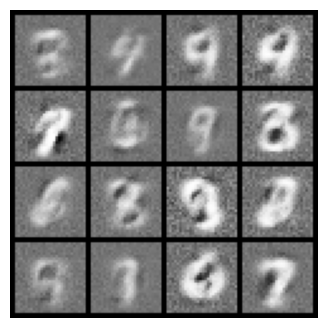

In [8]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

# --- SETUP ---
device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available
z_dim = 64      # Size of the noise vector (latent space)
batch_size = 32 # Number of images in each training batch

# --- DATA LOADING ---
# Download MNIST and convert images to tensors (normalized to [-1,1])
mnist = torchvision.datasets.MNIST('./data', download=True,
                                  transform=torchvision.transforms.ToTensor())
loader = torch.utils.data.DataLoader(mnist, batch_size=batch_size, shuffle=True)

# --- MODELS ---
# Generator: Takes random noise and outputs fake images
G = nn.Sequential(
    nn.Linear(z_dim, 256),  # Noise → hidden layer
    nn.ReLU(),              # Activation function
    nn.Linear(256, 784),    # Hidden → output (28x28=784 pixels)
    nn.Tanh()               # Output activation (values between -1 and 1)
).to(device)

# Discriminator: Takes images and outputs probability of being real
D = nn.Sequential(
    nn.Linear(784, 256),    # Image → hidden layer
    nn.LeakyReLU(0.2),      # Leaky activation prevents dead neurons
    nn.Linear(256, 1),      # Hidden → output (single probability)
    nn.Sigmoid()            # Output activation (0-1 probability)
).to(device)

# --- OPTIMIZERS ---
g_optim = torch.optim.Adam(G.parameters(), lr=0.0002)  # Generator optimizer
d_optim = torch.optim.Adam(D.parameters(), lr=0.0002)  # Discriminator optimizer
loss_fn = nn.BCELoss()  # Binary Cross Entropy Loss

# --- TRAINING ---
for epoch in range(10):  # 5 epochs is enough for basic results
    for real_imgs, _ in loader:
        curr_batch_size = real_imgs.size(0)  # Handle last batch which might be smaller

        # Prepare real and fake labels
        real_labels = torch.ones(curr_batch_size, 1).to(device)
        fake_labels = torch.zeros(curr_batch_size, 1).to(device)

        # Reshape images to flat vector
        real_imgs = real_imgs.view(-1, 784).to(device)

        # 1. TRAIN DISCRIMINATOR
        d_optim.zero_grad()  # Reset gradients

        # 1a. Train on real images
        pred_real = D(real_imgs)
        d_real_loss = loss_fn(pred_real, real_labels)

        # 1b. Train on fake images
        z = torch.randn(curr_batch_size, z_dim).to(device)  # Random noise
        fake_imgs = G(z)                                    # Generate fake images
        pred_fake = D(fake_imgs.detach())  # detach to avoid training G
        d_fake_loss = loss_fn(pred_fake, fake_labels)

        # Combined discriminator loss
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optim.step()

        # 2. TRAIN GENERATOR
        g_optim.zero_grad()  # Reset gradients
        pred_fake = D(fake_imgs)  # Now D's gradients don't matter
        g_loss = loss_fn(pred_fake, real_labels)  # G wants D to think fakes are real
        g_loss.backward()
        g_optim.step()

    print(f"Epoch {epoch+1}/5 - D loss: {d_loss.item():.4f}, G loss: {g_loss.item():.4f}")

# --- GENERATE IMAGES ---
with torch.no_grad():  # No need to track gradients for generation
    z = torch.randn(16, z_dim).to(device)  # Random noise for 16 images
    samples = G(z).view(-1, 1, 28, 28).cpu()  # Generate and reshape to images

    # Create a grid of images
    grid = torchvision.utils.make_grid(samples, nrow=4, normalize=True)

    # Display the grid
    plt.figure(figsize=(4, 4))
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')
    plt.savefig('mnist_gan_results.png')
    plt.show()